In [1]:
import json

import numpy as np
import sympy as sym 
import pandas as pd

import scipy.integrate
import matplotlib.pyplot as plt

from itertools import permutations

# Five state models

## Combinatorial network generation

In [2]:
## Enumerate state sequences and associated transitions
bound_states = ['RB', 'RN', 'RP', 'RW']
full_states = bound_states + ['R', 'N', 'P', 'W']

transitions_list = []
sequence_list = list(permutations(bound_states))

state_ids = {k: v for v, k in enumerate(full_states)}
state_symbols = {k: sym.symbols(k) for k in full_states}

for sequence in sequence_list:
    transitions = [('R', sequence[0])]

    for s1, s2 in zip(sequence[:-1], sequence[1:]):
        transitions.append((s1, s2))
        transitions.append((s2, s1))

    transitions.append((sequence[-1], 'R'))
    transitions_list.append(transitions)

In [3]:
## Work out dynamical equations
rhs_list = []
rate_symbols_list = []

for transitions in transitions_list:
    rhs = sym.zeros(len(state_symbols), 1)
    rate_symbols = {(s1, s2): sym.symbols(f"k_{s1[-1]}{s2[-1]}") for s1, s2 in transitions}

    for s1, s2 in transitions:        
        if s2[-1] not in ['R', 'B']:
            rhs[state_ids[s1]] -= rate_symbols[(s1, s2)] * state_symbols[s1] * state_symbols[s2[-1]]
            rhs[state_ids[s2]] += rate_symbols[(s1, s2)] * state_symbols[s1] * state_symbols[s2[-1]]

        else:
            rhs[state_ids[s1]] -= rate_symbols[(s1, s2)] * state_symbols[s1]
            rhs[state_ids[s2]] += rate_symbols[(s1, s2)] * state_symbols[s1]

    rhs[state_ids['N']] = -rhs[state_ids['RN']]
    rhs[state_ids['P']] = -rhs[state_ids['RP']]
    rhs[state_ids['W']] = -rhs[state_ids['RW']]

    rhs_list.append(rhs)
    rate_symbols_list.append(rate_symbols)


## Parameter inference

In [4]:
biophys_df = pd.read_csv('../data/biophysical_params_HeLa.csv', comment='#')#, delimiter=',')#,quotechar='"')

parameter_dict_wt = dict(zip(biophys_df['parameter'].values, biophys_df['value'].values))

In [5]:
## Set parameters and variables
parameters = sym.symbols(list(parameter_dict_wt.keys()))
tau_N, F_N, N_N, tau_P, F_P, N_P, tau_W, F_W, N_W, tau_R, F_R, N_R = parameters

variables = state_symbols.values()
RB, RN, RP, RW, R, N, P, W = variables

In [6]:
## Set substitution dictionaries for equilibrium concentrations
subs_dict = {'RB': N_R * F_R - N_N * F_N - N_P * F_P - N_W * F_W,
             'RN': N_N * F_N,
             'RP': N_P * F_P,
             'RW': N_W * F_W,
             'R': N_R * (1 - F_R),   
             'N': N_N * (1 - F_N),
             'P': N_P * (1 - F_P),
             'W': N_W * (1 - F_W)}

subs_R = {k: v for k, v in subs_dict.items() if k not in ['R']}
subs_N = {k: v for k, v in subs_dict.items() if k not in ['N', 'RN']}
subs_P = {k: v for k, v in subs_dict.items() if k not in ['P', 'RP']}
subs_W = {k: v for k, v in subs_dict.items() if k not in ['W', 'RW']}

In [7]:
## Map cohesin transition rates to PDS5/WAPL/NIPBL/PDS5 measurements
rate_dict_list = []

for i, rhs in enumerate(rhs_list):
    rate_dict = {}

    rate_symbols = rate_symbols_list[i]
    rhs_eq = sym.zeros(len(rate_symbols), 1)

    eq_R = rhs[state_ids['R']].subs(subs_R)
    eq_N = rhs[state_ids['N']].subs(subs_N)
    eq_P = rhs[state_ids['P']].subs(subs_P)
    eq_W = rhs[state_ids['W']].subs(subs_W)

    # Equilibrium subunit bound fractions
    rhs_eq[state_ids['R']] = sym.collect(eq_R, R).coeff(R, 1) + 1/tau_R * F_R / (1-F_R)
    rhs_eq[state_ids['N']] = sym.collect(eq_N, N).coeff(N, 1) + 1/tau_N * F_N / (1-F_N)
    rhs_eq[state_ids['P']] = sym.collect(eq_P, P).coeff(P, 1) + 1/tau_P * F_P / (1-F_P)
    rhs_eq[state_ids['W']] = sym.collect(eq_W, W).coeff(W, 1) + 1/tau_W * F_W / (1-F_W)

    # Equilibrium subunit residence times
    rhs_eq[state_ids['RB']] = sym.collect(eq_R, R).coeff(R, 0) - N_R*F_R/tau_R
    rhs_eq[state_ids['RN']] = sym.collect(eq_N, RN).coeff(RN, 1) - 1/tau_N
    rhs_eq[state_ids['RP']] = sym.collect(eq_P, RP).coeff(RP, 1) - 1/tau_P
    rhs_eq[state_ids['RW']] = sym.collect(eq_W, RW).coeff(RW, 1) - 1/tau_W

    sol_rates = sym.solve(rhs_eq, *rate_symbols.values())

    for rate, expr in sol_rates.items():
        value = expr.evalf(subs=parameter_dict_wt)
        rate_dict[str(rate)] = value

    rate_dict_list.append(rate_dict)


In [8]:
# Enumerate all models with physical kinetics (i.e. positive rates)
candidate_list = []

for sequence, rate_dict in zip(sequence_list, rate_dict_list):
    has_physical_kinetics = all(value > 0 for value in rate_dict.values())
            
    if has_physical_kinetics:
        candidate_list.append(sequence)

print(candidate_list)

[('RB', 'RP', 'RN', 'RW'), ('RN', 'RB', 'RP', 'RW'), ('RN', 'RP', 'RB', 'RW'), ('RP', 'RB', 'RN', 'RW'), ('RW', 'RB', 'RP', 'RN'), ('RW', 'RN', 'RB', 'RP'), ('RW', 'RN', 'RP', 'RB'), ('RW', 'RP', 'RB', 'RN')]


## Time integration

In [9]:
## Set initial state and integration time interval
init_state = sym.Matrix([[0, 0, 0, 0, # Starting from completely unbound population of RAD21
                          N_R, N_N, N_P, N_W]]) # Degrons can now be simulated by updating protein levels directly from init_state

t = sym.symbols('t') 
t_eval = np.linspace(0, 60 * 60, 10000) # evaluate integral from t = 0-60 minutes for 10000 points

tspan = (t_eval[0], t_eval[-1])

In [10]:
# Integrate coupled mass action equations
def solve_kinetics(rhs, rate_dict, parameter_dict):
    rhs_eval = list(rhs.evalf(subs=rate_dict))
    y0 = list(init_state.evalf(subs=parameter_dict))

    f = sym.lambdify((t, variables), rhs_eval)

    solution = scipy.integrate.solve_ivp(f, tspan, y0, t_eval=t_eval)

    return solution.y

In [11]:
# Get change in bound fraction of a given species
def relative_bound(species, parameter_dict_wt, parameter_dict_mut, final_state_wt, final_state_mut):                
    if species in state_symbols:
        abundance_key = f"N_{species}"

        wt_bound = parameter_dict_wt[abundance_key] - final_state_wt[state_ids[species]]
        mut_bound = parameter_dict_mut[abundance_key] - final_state_mut[state_ids[species]]

        return mut_bound / wt_bound
    
    else:
        raise ValueError('Perturbation consequence not in known state symbols')

In [12]:
# pertubation = [perturb_param, perturb_ratio, conditions={species:relative_bound_ratio}]
perturbations = [
    ['N_W', 1/5, {'R':'>1'}], #F_R goes up in dWAPL: Wutz2017 Fig4F 
    ['N_P', 1/5, {'R':'>1'}],  #F_R goes up in dPDS5: Wutz2017 Fig4F
    ['N_N', 1/5, {'R':'<1'}],  #F_R goes down in dNIPBL: Haarhuis2017 Fig4E
]

In [13]:
verbose = False

# Enumerate all models satisfying experimental constraints
for sequence, rhs, rate_dict in zip(sequence_list, rhs_list, rate_dict_list):
    if sequence in candidate_list:
        final_state_wt = solve_kinetics(rhs, rate_dict, parameter_dict_wt)[:,-1]
        check_list = []

        for perturbation in perturbations:
            perturbation_param, perturbation_ratio, consequences = perturbation
            
            parameter_dict_mut = parameter_dict_wt.copy()
            parameter_dict_mut[perturbation_param] *= perturbation_ratio

            final_state_mut = solve_kinetics(rhs, rate_dict, parameter_dict_mut)[:,-1]

            for species, value in consequences.items():
                ratio = relative_bound(species, parameter_dict_wt, parameter_dict_mut, final_state_wt, final_state_mut)                
                check_list.append(eval(f"{ratio}{value}"))
        
        if verbose: 
            print(check_list)

        if not np.array(check_list).all():
            candidate_list.remove(sequence)

print(candidate_list)

[('RN', 'RB', 'RP', 'RW')]


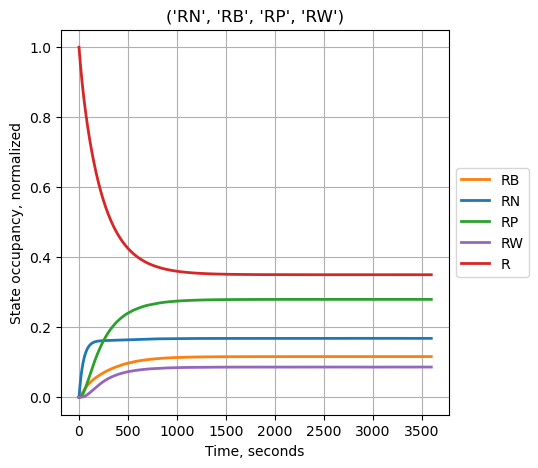

In [14]:
figwidth = 5

solution_list = []

for sequence in candidate_list:
    i = sequence_list.index(sequence)

    rhs = rhs_list[i]    
    rate_dict = rate_dict_list[i]

    solution = solve_kinetics(rhs, rate_dict, parameter_dict_wt)

    solution_list.append(solution)

    fig = plt.figure(figsize=(figwidth, figwidth)) 
    ax = plt.subplot(1,1,1)

    ax.set_prop_cycle('color', ['#ff7f0e', '#1f77b4', '#2ca02c', '#9467bd', '#d62728'])

    plt.plot(t_eval, solution[:5].T / parameter_dict_wt['N_R'], lw=2) 

    ax.legend(list(variables)[:5], shadow=False,
              loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(sequence)

    plt.grid(True)

    _ = plt.xlabel('Time, seconds')
    _ = plt.ylabel('State occupancy, normalized')

In [15]:
# Output rates to dictionary
variable_list = list(map(str, variables))

for sequence, solution in zip(candidate_list, solution_list):
    final_state = solution[:,-1]

    with open("../data/extrusion_dict_HeLa_twostate.json", 'r') as dict_file:
        extrusion_dict = json.load(dict_file) 

    i = sequence_list.index(sequence)
    rate_dict = rate_dict_list[i]

    active_index = variable_list.index('RN')
    rescale_velocity = parameter_dict_wt['F_R'] * parameter_dict_wt['N_R'] / final_state[active_index]

    extrusion_dict["velocity_multiplier"] *= rescale_velocity
    extrusion_dict["LEF_states"] = {k: v+1 for v, k in enumerate(sequence)}

    for rate, value in rate_dict.items():
        s1 = f"R{rate[-2]}"
        s2 = f"R{rate[-1]}"

        id1 = sequence.index(s1)+1 if s1 in sequence else 0
        id2 = sequence.index(s2)+1 if s2 in sequence else 0

        rate_key = f"{id1}{id2}"
    
        if rate[-1] not in ['R', 'B']:
            k = variable_list.index(rate[-1])
            value *= final_state[k]

        if (id1 != 0) & (id2 != 0):
            extrusion_dict["LEF_transition_rates"][rate_key] = {"A": float(value)}
        elif id1 == 0:
            extrusion_dict["LEF_on_rate"] = {"A": float(value)}
        elif id2 == 0:
            extrusion_dict["LEF_off_rate"] = {"A": float(value)}
            extrusion_dict["LEF_stalled_off_rate"] = {"A": float(value)}

    sequence_string = "_".join(sequence)

    output_kin_path = f"../data/state_kinetics_HeLa_{sequence_string}.res"
    output_dict_path = f"../data/extrusion_dict_HeLa_{sequence_string}.json"

    ordered_solution = solution[np.argsort(list(sequence) + ['R'])]
    np.savetxt(output_kin_path, np.r_[t_eval[None,:], ordered_solution].T)

    with open(output_dict_path, 'w') as output_dict_file:
        json.dump(extrusion_dict, output_dict_file, indent=4)


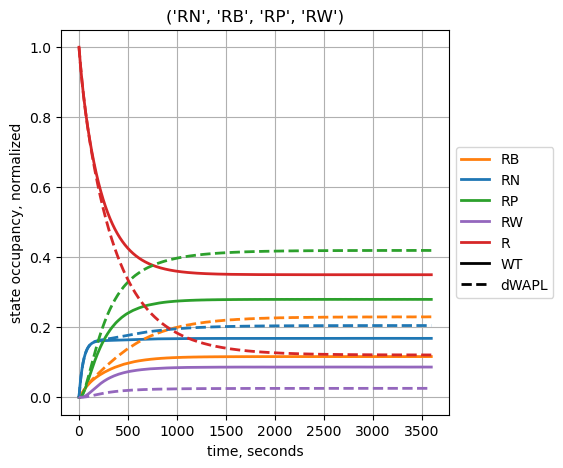

In [16]:
# Simulate WAPL depletion
for sequence, solution in zip(candidate_list, solution_list):
    i = sequence_list.index(sequence)
        
    rhs = rhs_list[i]    
    rate_dict = rate_dict_list[i]

    parameter_dict_dWAPL = parameter_dict_wt.copy()
    parameter_dict_dWAPL['N_W'] /= 5
    
    solution_dWAPL = solve_kinetics(rhs, rate_dict, parameter_dict_dWAPL)

    fig = plt.figure(figsize=(figwidth, figwidth)) 
    ax = plt.subplot(1,1,1)

    ax.set_prop_cycle('color', ['#ff7f0e', '#1f77b4', '#2ca02c', '#9467bd', '#d62728'])

    plt.plot(t_eval, solution[:5].T / parameter_dict_wt['N_R'], lw=2) 

    plt.plot([], [], 'k', lw=2) 
    plt.plot([], [], 'k--', lw=2) 

    plt.plot(t_eval, solution_dWAPL[:5].T / parameter_dict_dWAPL['N_R'], ls='--', lw=2) 

    ax.legend(list(variables)[:5]+['WT', 'dWAPL'], shadow=False,
              loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(sequence)

    plt.grid(True)

    _ = plt.xlabel('time, seconds')
    _ = plt.ylabel('state occupancy, normalized')

    